# `xesmf` for unstructured grids like `ICON`

- https://github.com/pangeo-data/xESMF
- https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Using_LocStream.html

In [5]:
import xarray as xr

In [2]:
#path = '/work/bm1102/m211054/dyamond/zstar2/experiments/exp.ocean_era51h_zstar_r2b9_21223-DWS/outdata/exp.ocean_era51h_zstar_r2b9_21223-DWS_P1M_3d_20160901T000000Z.nc'
path = '/work/mh0033/m211054/projects/icon/icon-oes-1.3.01/experiments/exp.ocean_era51h_r2b8_hel20218-ERA/outdata/exp.ocean_era51h_r2b8_hel20218-ERA_19970401T000000Z.nc'
ds = xr.open_dataset(path,
                     chunks={'depth': 1})

In [ ]:
ds.coords

In [6]:
def rad_to_deg(ds):
    """Convert radian units to deg."""
    import numpy as np
    #ds.coords.compute()
    with xr.set_options(keep_attrs=True):
        for c in ds.coords:
            if 'units' in ds[c].attrs:
                if ds[c].attrs['units'] == 'radian':
                    print(f'convert {c} from rad to deg')
                    ds[c] = ds[c]* 180./np.pi
                    ds[c].attrs['units'] = 'degrees'
            elif 'bnds' in c:
                print(f'convert {c} from rad to deg')
                ds[c] = ds[c]* 180./np.pi
                ds[c].attrs['units'] = 'degrees'
    return ds

In [ ]:
ds = rad_to_deg(ds)

In [11]:
ds = ds[['to']]

In [9]:
ds_2d = ds.isel(depth=0)

In [7]:
import xesmf as xe
import matplotlib.pyplot as plt

ds_out = xe.util.grid_global(1,1)

/work/mh0727/m300524/conda-envs/pymistral/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


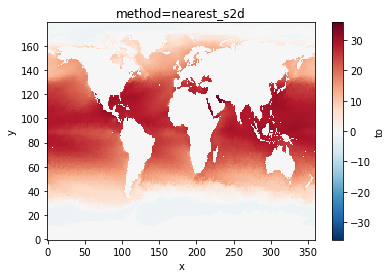

/work/mh0727/m300524/conda-envs/pymistral/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


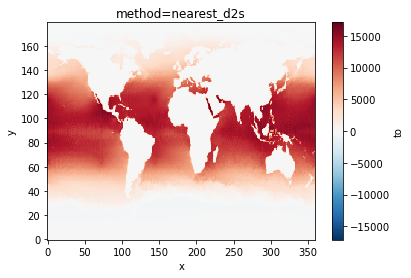

In [12]:
for method in ['nearest_s2d','nearest_d2s']:
    re = xe.Regridder(ds_2d, ds_out, method, locstream_in=True)
    ds_re = re(ds_2d)
    ds_re.squeeze().to.plot()
    plt.title(f'method={method}')
    plt.show()

> `nearest_s2d` looks fine

> `nearest_d2s` shows a fine pattern but values are off

## generate weights

In [13]:
%time re = xe.Regridder(ds_2d, ds_out, method='nearest_s2d', locstream_in=True)

CPU times: user 45.9 s, sys: 1.44 s, total: 47.3 s
Wall time: 47.3 s


In [14]:
%time re.to_netcdf('weights.nc')

CPU times: user 9 ms, sys: 5 ms, total: 14 ms
Wall time: 23.8 ms


'weights.nc'

In [15]:
!du -hs weights.nc

1020K	weights.nc


In [48]:
# reuse
re = xe.Regridder(ds_2d, ds_out, method='nearest_s2d', locstream_in=True, weights=xr.open_dataset('weights.nc'))

### single level

In [40]:
%time ds_re = re(ds_2d)

CPU times: user 6 ms, sys: 4 ms, total: 10 ms
Wall time: 6.38 ms


/work/mh0727/m300524/conda-envs/pymistral/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [41]:
ds_re.to.data

dask.array<transpose, shape=(1, 180, 360), dtype=float64, chunksize=(1, 180, 360), chunktype=numpy.ndarray>

In [42]:
%time ds_re = ds_re.compute()

CPU times: user 63 ms, sys: 32 ms, total: 95 ms
Wall time: 92.8 ms


### all levels

In [16]:
%time ds_re = re(ds)

CPU times: user 13 ms, sys: 4 ms, total: 17 ms
Wall time: 14.2 ms


/work/mh0727/m300524/conda-envs/pymistral/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [17]:
ds_re.to.data

dask.array<transpose, shape=(1, 128, 180, 360), dtype=float64, chunksize=(1, 1, 180, 360), chunktype=numpy.ndarray>

In [18]:
%time ds_re = ds_re.compute()

CPU times: user 26.9 s, sys: 27.8 s, total: 54.7 s
Wall time: 47.3 s


# R2B9

In [28]:
#!ncdump -h /work/bm1102/m211054/dyamond/zstar2/experiments/exp.ocean_era51h_zstar_r2b9_21223-DWS/outdata/exp.ocean_era51h_zstar_r2b9_21223-DWS_P1M_3d_20160901T000000Z.nc

In [82]:
ds = xr.open_mfdataset('/work/bm1102/m211054/dyamond/zstar2/experiments/exp.ocean_era51h_zstar_r2b9_21223-DWS/outdata/exp.ocean_era51h_zstar_r2b9_21223-DWS_P1M_3d_20160901T000000Z.nc',
                     chunks={'depth': 4}, parallel=True)[['to']]
ds

<xarray.Dataset>
Dimensions:  (depth: 128, ncells: 14886338, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2016-09-01
    clon     (ncells) float32 dask.array<chunksize=(14886338,), meta=np.ndarray>
    clat     (ncells) float32 dask.array<chunksize=(14886338,), meta=np.ndarray>
  * depth    (depth) float64 1.0 3.05 5.2 7.45 ... 5.522e+03 5.71e+03 5.904e+03
Dimensions without coordinates: ncells
Data variables:
    to       (time, depth, ncells) float32 dask.array<chunksize=(1, 4, 14886338), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.2 (http://mpimet...
    Conventions:          CF-1.6
    number_of_grid_used:  42
    uuidOfHGrid:          7d4df6e2-1b06-11e8-9572-8146aa8bc243
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               git@gitlab.dkrz.de:icon/icon-oes.git@7ab1ae25a1b38c...
    history:              /mnt/lustre02/work/bm1102/m211054/dyamond/zstar2/bi...
    references:           see MPIM/DWD publications
    comment:              Helmuth Haak (m211054) on m20000 (Linux 2.6.32-754....

In [83]:
ds = rad_to_deg(ds)

convert clon from rad to deg
convert clat from rad to deg


In [85]:
%time ds.to_zarr('/work/mh0727/m300524/ICON/R2B9.zarr', mode='w', consolidated=True)

CPU times: user 1min 46s, sys: 38.2 s, total: 2min 25s
Wall time: 1min 9s


In [86]:
ds = xr.open_zarr('/work/mh0727/m300524/ICON/R2B9.zarr', consolidated=True)

In [74]:
ds.coords['clon']=ds.coords['clon'].compute()
ds.coords['clat']=ds.coords['clat'].compute()

In [40]:
%time re = xe.Regridder(ds.isel(depth=0,drop=True).compute(), ds_out, method='nearest_s2d', locstream_in=True)

CPU times: user 46.5 s, sys: 1.67 s, total: 48.2 s
Wall time: 48 s


In [41]:
# same weights
%time re.to_netcdf('weights.nc')

CPU times: user 8 ms, sys: 7 ms, total: 15 ms
Wall time: 21.1 ms


'weights.nc'

In [63]:
# use dask
from dask.distributed import Client
import multiprocessing
ncpu = multiprocessing.cpu_count()
processes = False
nworker = 8
threads = ncpu // nworker
print(
    f"Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}, processes: {processes}",
)
client = Client(
    processes=processes,
    threads_per_worker=threads,
    n_workers=nworker,
    memory_limit="64GB",
)
client

Number of CPUs: 72, number of threads: 9, number of workers: 8, processes: False


/work/mh0727/m300524/conda-envs/pymistral/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44834 instead
  warnings.warn(


<Client: 'inproc://10.50.43.213/52896/150' processes=8 threads=72, memory=476.84 GiB>

In [87]:
# use pre-calculated weights
%time re = xe.Regridder(ds.isel(depth=0), ds_out, method='nearest_s2d', locstream_in=True, weights=xr.open_dataset('weights.nc'))

CPU times: user 702 ms, sys: 450 ms, total: 1.15 s
Wall time: 740 ms


In [88]:
# with persist, compute() only takes 3s, without 50s
# %time ds = ds.persist()

In [89]:
%time ds_re = re(ds)

CPU times: user 28 ms, sys: 14 ms, total: 42 ms
Wall time: 35.7 ms


/work/mh0727/m300524/conda-envs/pymistral/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [90]:
ds_re.to.data

dask.array<transpose, shape=(1, 128, 180, 360), dtype=float64, chunksize=(1, 4, 180, 360), chunktype=numpy.ndarray>

In [91]:
%time ds_re = ds_re.compute()

CPU times: user 14.7 s, sys: 1min 29s, total: 1min 44s
Wall time: 6.26 s


- with `zarr` dump: 5s
- from `nc`: 50s

In [92]:
client.close()